In [1]:
%matplotlib inline
import sklearn
import pandas
import numpy
import matplotlib.pyplot as plt

import trackml.dataset
import trackml.score

import os.path
import sys

In [2]:
path_to_train = 'train_100_events.zip'
event_prefix = "event000001001"
#path = os.path.join(path_to_train, event_prefix)
path = 'train_sample.zip'

events = pandas.DataFrame()
datas = []
for e in trackml.dataset.load_dataset(path, nevents=3):
    event_id, hits, cells, particles, truth = e
    data = hits.merge(truth)
    data['event_id'] = event_id
    events = data
    datas.append(data)
events = pandas.concat(datas)

events.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,event_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000,1000
1,2,-55.336102,0.635342,-1502.5,7,2,1,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010,1000
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000,1000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008,1000
4,5,-62.673599,-9.371200,-1502.5,7,2,1,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009,1000


In [3]:
events['event_id'].unique(), len(events)

(array([1000, 1001, 1002]), 340123)

In [4]:
len(events['layer_id'].unique()), len(events['volume_id'].unique()), len(events['module_id'].unique())

(7, 9, 3186)

In [5]:
events[events['particle_id'] == 22525763437723648]

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,event_id
1,2,-55.336102,0.635342,-1502.500000,7,2,1,22525763437723648,-55.338501,0.630805,-1502.500000,-0.570605,0.028390,-15.49220,0.000010,1000
1419,1420,-55.162201,0.604841,-1497.500000,7,2,106,22525763437723648,-55.154400,0.621779,-1497.500000,-0.569794,0.027264,-15.49280,0.000008,1000
1459,1460,-47.975498,0.311848,-1302.500000,7,4,1,22525763437723648,-47.988098,0.315591,-1302.500000,-0.568883,0.021994,-15.49290,0.000006,1000
3169,3170,-47.812302,0.327322,-1297.500000,7,4,106,22525763437723648,-47.804100,0.308733,-1297.500000,-0.571445,0.020847,-15.49330,0.000005,1000
3233,3234,-40.622799,0.088046,-1102.500000,7,6,1,22525763437723648,-40.626099,0.087326,-1102.500000,-0.569940,0.015274,-15.49340,0.000005,1000
5342,5343,-40.438801,0.098098,-1097.500000,7,6,106,22525763437723648,-40.442200,0.082538,-1097.500000,-0.570204,0.013872,-15.49400,0.000006,1000
5423,5424,-35.480598,-0.008800,-962.500000,7,8,1,22525763437723648,-35.475899,-0.024284,-962.500000,-0.569773,0.010668,-15.49400,0.000009,1000
5481,5482,-35.330101,-0.023294,-958.000000,7,8,4,22525763437723648,-35.310101,-0.027160,-958.000000,-0.571644,0.008881,-15.49490,0.000011,1000
7866,7867,-35.312302,-0.004440,-957.500000,7,8,106,22525763437723648,-35.291698,-0.027451,-957.500000,-0.571617,0.009012,-15.49500,0.000014,1000
7950,7951,-30.333700,-0.105277,-822.500000,7,10,1,22525763437723648,-30.315399,-0.095482,-822.500000,-0.570993,0.006231,-15.49510,0.000016,1000


In [6]:
events.columns

Index(['hit_id', 'x', 'y', 'z', 'volume_id', 'layer_id', 'module_id',
       'particle_id', 'tx', 'ty', 'tz', 'tpx', 'tpy', 'tpz', 'weight',
       'event_id'],
      dtype='object')

In [36]:
from sklearn.preprocessing import StandardScaler

def single_features(hits):
    
    # From DBSCAN benchmark
    # https://www.kaggle.com/mikhailhushchyn/dbscan-benchmark
    x = hits.x.values
    y = hits.y.values
    z = hits.z.values
    xy_scale = numpy.sqrt(x**2 + y**2 + z**2)
    xnorm = x/xy_scale
    ynorm = y/xy_scale
    z_scale = numpy.sqrt(x**2 + y**2)
    znorm = z/z_scale
    
    nn = StandardScaler().fit_transform([xnorm, ynorm, znorm])
    features = pandas.DataFrame({
        'particle_id': hits['particle_id'],
        'xnorm': nn[0],
        'ynorm': nn[1],
        'znorm': nn[2],
    })
    
    return features

hits = single_features(events)

In [114]:
# Sample hits for training, a mix of hits from same track and from different
def make_pairs(df, idcol='particle_id'):
    p = (df.merge(df, on=df.assign(key_col=1)['key_col'], suffixes=('_a', '_b'))
      #.query('{}_b != {}_a'.format(idcol, idcol)) # filter out joins on the same row
      .reset_index(drop=True))
    return p

def training_sample(hits, n_particles, n_hits=20, random_state=None):
    particles = hits['particle_id'].sample(n=n_particles, random_state=random_state)
    samples = []
    for particle in particles:
        matches = hits[hits['particle_id'] == particle].sample(n=n_hits, replace=True, random_state=random_state)
        nonmatches = hits[hits['particle_id'] != particle].sample(n=n_hits//2, replace=True, random_state=random_state)
        samples.append(matches)
        samples.append(nonmatches)

    samples = pandas.concat(samples)
    return samples

def sample_pairs_indirect(n_particles, random_state=None):
    t = training_sample(hits, n_particles, random_state=random_state)
    pairs = make_pairs(t)
    pairs['matches'] = pairs['particle_id_a'] == pairs['particle_id_b']
    return pairs

def equalize_matches(pairs):
    add = pairs.shape[0]
    match_equalizer = pairs[pairs.matches==True].sample(n=add, replace=True)
    pairs = pandas.concat([pairs, match_equalizer])
    return pairs

def sample_pairs(n_particles, n_hits=10, random_state=None):
    
    particles = hits['particle_id'].sample(n=n_particles, random_state=random_state)
    samples = []
    for particle in particles:
        matches = hits[hits['particle_id'] == particle].sample(n=n_hits, replace=True, random_state=random_state)
        nonmatches = hits[hits['particle_id'] != particle].sample(n=n_hits, replace=True, random_state=random_state)

        d = pandas.concat([matches, nonmatches])
        pairs = make_pairs(d)
        pairs['matches'] = pairs['particle_id_a'] == pairs['particle_id_b']        
        samples.append(pairs)

    samples = pandas.concat(samples)
    return samples


In [115]:
def pair_features(pairs): 
    features = pandas.DataFrame()

    # Distance
    features['xd'] = pairs['xnorm_a'] - pairs['xnorm_b']
    features['yd'] = pairs['ynorm_a'] - pairs['ynorm_b']
    features['zd'] = pairs['znorm_a'] - pairs['znorm_b']
    
    # Position
    #features['xa'] = pairs['xnorm_a']
    #features['ya'] = pairs['ynorm_a']
    #features['za'] = pairs['znorm_a']
    
    # Target
    features['matches'] = pairs['matches']
    
    return features

pairs = sample_pairs(100, random_state=2)
data = pair_features(pairs)
data.shape, data.matches.mean(), len(pairs['particle_id_a'].unique())

#data[data.matches==False].head(n=2)
#data[data.matches==True].head(n=2)

((40000, 4), 0.2932, 207)

In [103]:
#data[['xd', 'yd', 'zd']].groupby(data['matches']).hist(figsize=(16,8), bins=40, alpha=0.8)

In [104]:
# From http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=numpy.linspace(.1, 1.0, 5), metric=None):
    np = numpy
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    s = model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=metric)
    train_sizes, train_scores, test_scores = s
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [105]:
def plot_forest_importance(forest, X):
    importances = forest.feature_importances_
    std = numpy.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = numpy.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %d : %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]), )

    # Plot the feature importances of the forest
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title("Feature importances")
    ax.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    #ax.set_xticks(range(X.shape[1]), indices)
    #ax.set_xlim([-1, X.shape[1]])
    return fig

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] min_samples_split=0.1, n_estimators=40 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=40, total=   1.3s
[CV] min_samples_split=0.1, n_estimators=40 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ........... min_samples_split=0.1, n_estimators=40, total=   1.4s
[CV] min_samples_split=0.1, n_estimators=40 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=40, total=   1.3s
[CV] min_samples_split=0.1, n_estimators=80 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=80, total=   2.7s
[CV] min_samples_split=0.1, n_estimators=80 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=80, total=   3.1s
[CV] min_samples_split=0.1, n_estimators=80 ..........................
[CV] ........... min_samples_split=0.1, n_estimators=80, total=   2.9s
[CV] min_samples_split=0.01, n_estimators=40 .........................
[CV] .......... min_samples_split=0.01, n_estimators=40, total=   2.0s
[CV] min_samples_split=0.01, n_estimators=40 .........................
[CV] .......... min_samples_split=0.01, n_estimators=40, total=   2.2s
[CV] min_samples_split=0.01, n_estimators=40 .........................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   36.0s finished


Using parameters {'min_samples_split': 0.01, 'n_estimators': 80}
Test set score: 0.89


<module 'matplotlib.pyplot' from '/usr/lib/python3.6/site-packages/matplotlib/pyplot.py'>

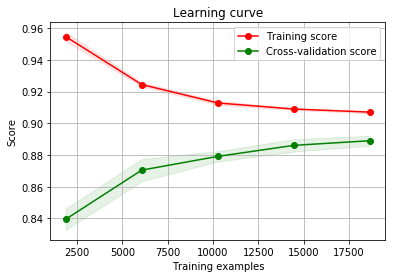

In [120]:
from sklearn import model_selection, metrics

test_size = 0.3
seed = 1

target_columns = ['matches']
data_columns = list(set(data.columns) - set(target_columns))

s = model_selection.train_test_split(data[data_columns], data[target_columns], test_size=test_size, random_state=seed)
X_train, X_test, Y_train, Y_test = s
Y_train = Y_train['matches']
Y_test = Y_test['matches']

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

metric = 'average_precision'

estimator = RandomForestClassifier()
parameters = {
    'n_estimators': [ 40, 80 ],
    'min_samples_split': [ 0.1, 0.01 ],
}
search = model_selection.GridSearchCV(estimator, parameters, cv=3, verbose=2, scoring=metric)
search.fit(X_train, Y_train)

# Evaluation
print('Using parameters', search.best_params_)
score = metrics.get_scorer(metric)(search.best_estimator_, X_test, Y_test)
print('Test set score: %.2f' % (score,))

plot_learning_curve(search.best_estimator_, 'Learning curve', X_train, Y_train, metric=metric)

In [121]:
cm = metrics.confusion_matrix(search.best_estimator_.predict(X_test), Y_test)
cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

array([[0.86333547, 0.13666453],
       [0.11921033, 0.88078967]])

In [122]:
# Validation set
a = pair_features(sample_pairs(20, random_state=11))
b = pair_features(sample_pairs(20, random_state=12))
c = pair_features(sample_pairs(20, random_state=13))
validate = pandas.concat([a, b, c])
X_valid = validate[data_columns]
Y_valid = validate[target_columns]

cm = metrics.confusion_matrix(search.best_estimator_.predict(X_valid), Y_valid)
cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

array([[0.89196598, 0.10803402],
       [0.21106758, 0.78893242]])

Feature ranking:
1. 0 : yd (0.350965)
2. 1 : xd (0.332140)
3. 2 : zd (0.316895)


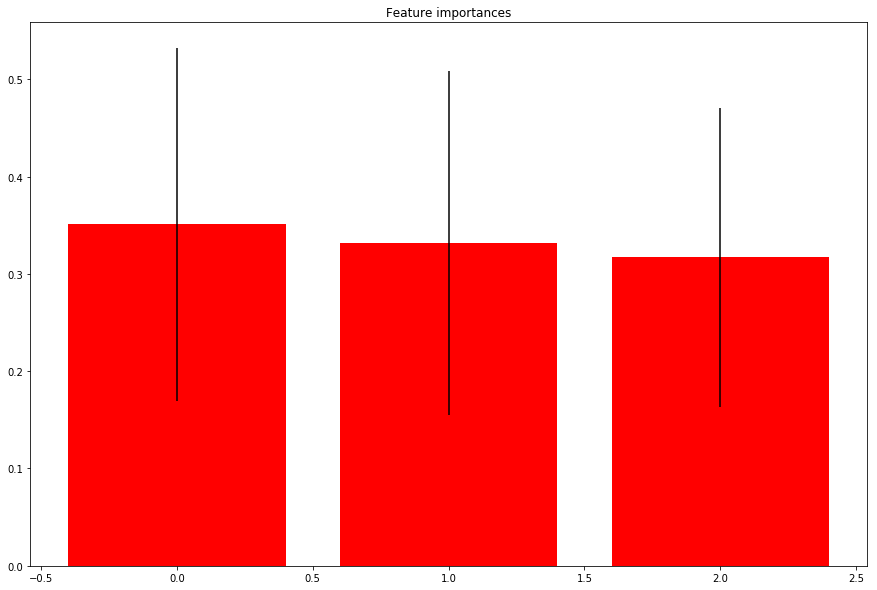

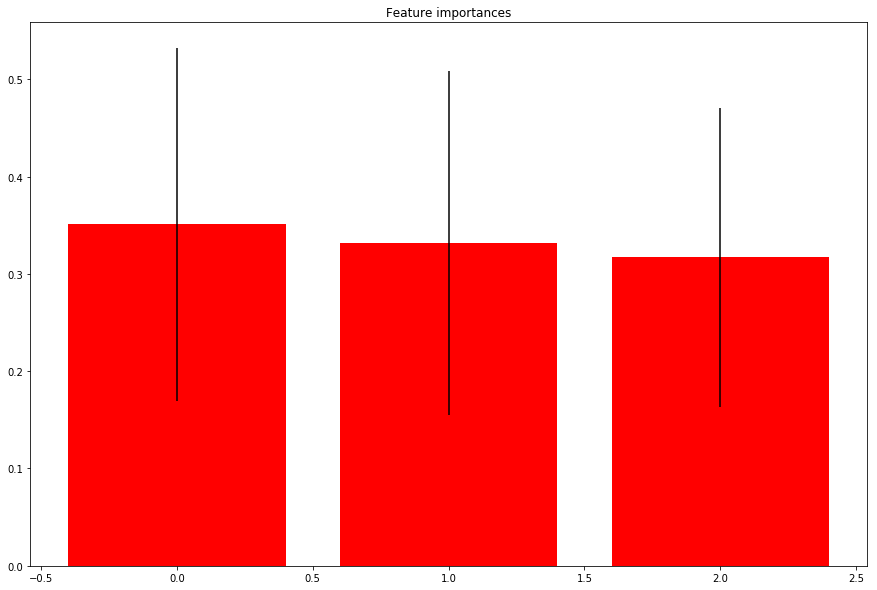

In [123]:
plot_forest_importance(search.best_estimator_, X_train)